# Probando XGBoost

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
pd.set_option('display.max_columns', 50)


In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12.0,8.0]

In [3]:
df_train = pd.read_csv("../data/palabras.csv")

In [4]:
def fill_m2(df):
    df['metrostotales'].fillna(df['metroscubiertos'], inplace=True)
    df['metroscubiertos'].fillna(df['metrostotales'], inplace=True)
    
    return df

In [5]:
df_train.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,anio,mes,dia,palabra_hermosa,...,palabra_servicios,palabra_servicio,palabra_estilo,palabra_frente,palabra_vista,palabra_visitas,palabra_parque,palabra_areas,palabra_estrenar,palabra_infonavit,palabra_residencial,palabra_escuela,palabra_exclusivo,palabra_lujo,palabra_esquina,palabra_refaccion,palabra_country,palabra_barra,palabra_lavado,palabra_renta,palabra_super,palabra_lago,palabra_bosque,palabra_avenida,palabra_hospital
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,2.0,80.0,80.0,23533.0,2015-08-23,0.0,0.0,0.0,0.0,0.0,2273000.0,2015,8,23,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,2.0,268.0,180.0,24514.0,2013-06-28,0.0,0.0,0.0,1.0,1.0,3600000.0,2013,6,28,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,2.0,144.0,166.0,48551.0,2015-10-17,0.0,0.0,0.0,0.0,0.0,1200000.0,2015,10,17,1,...,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,1.0,63.0,67.0,53666.0,2012-03-09,0.0,0.0,0.0,1.0,1.0,650000.0,2012,3,9,0,...,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,1.0,95.0,95.0,47835.0,2016-06-07,0.0,0.0,0.0,0.0,0.0,1150000.0,2016,6,7,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Pre-processing

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [54]:
def preprocess(df, OHE, BE, encodingType):
    features = df.copy()
    drop_cols = getDropCols()
    features = features.drop(drop_cols, axis=1)

    if (encodingType == 'train'):
        features = OHE.fit_transform(features)
        features = BE.fit_transform(features)
    else:
        features = OHE.transform(features)
        features = BE.transform(features)
        
    drop_cols = getOneHotCols()
    drop_cols.extend(getBinaryCols())

    display(drop_cols)
                
    #features = features.drop(drop_cols, axis=1)
    
    features = fill_m2(features)
    
    features_with_nans = features.columns[features.isna().any()].tolist()
    
    for feature in features_with_nans:
        features[feature] = features[feature].fillna(0)
        
    #imp = Imputer()
    #imp_cols = ['antiguedad', 'banos', 'habitaciones', 'garages']
    #X_train[imp_cols] = imp.fit_transform(X_train[imp_cols])
        
    return features    

In [49]:
display(getOneHotCols().extend(getBinaryCols()))

None

In [43]:
def getDropCols():
    return ['titulo', 'descripcion', 'direccion', 'id', 'anio', 'dia', 'mes', 'fecha'] # temporal

def getOneHotCols():
    return ['tipodepropiedad', 'provincia']

def getBinaryCols():
    return ['ciudad', 'idzona']

In [35]:
import category_encoders as ce

OHE = ce.OneHotEncoder(cols=getOneHotCols(), handle_unknown='ignore', use_cat_names=True)
BE = ce.BinaryEncoder(cols=getBinaryCols(), handle_unknown='ignore')

In [55]:
X = df_train.drop("precio", axis=1)
y = df_train['precio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train = preprocess(X_train, OHE, BE, 'train')
X_test = preprocess(X_test, OHE, BE, 'test')

['tipodepropiedad', 'provincia', 'ciudad', 'idzona']

['tipodepropiedad', 'provincia', 'ciudad', 'idzona']

In [12]:
from category_encoders import BinaryEncoder

In [56]:
print(f"Original shapes: X={X.shape} y={y.shape}")
print(f"Train shapes: X={X_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={X_test.shape}  y={y_test.shape}")

Original shapes: X=(240000, 77) y=(240000,)
Train shapes: X=(180000, 149) y=(180000,)
Test  shapes: X=(60000, 149)  y=(60000,)


## Training

In [57]:
from xgboost import XGBRegressor

In [62]:
xgb_model = XGBRegressor(n_estimators=400,max_depth=2,n_jobs=-1, learning_rate=0.01, objective="reg:squarederror")


In [63]:
xgb_model.fit(X_train, y_train, eval_metric="mae")

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=-1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [24]:
# Matriz de correlaciones como heatmap
#plt.figure(figsize=(15, 15))
#sns.heatmap(df_train.corr(), square=True, fmt='.2f');

## Predicciones

In [64]:
def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.predict(test_features)
    error = mean_absolute_error(test_labels, predict)
    score = model.score(test_features,test_labels)
    
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    print('Testeo: {:0.4f}%.'.format(score*100))
    print('Mean abs error: {:0.4f}.'.format(error))

In [65]:
predecir(xgb_model, X_train, y_train, X_test, y_test)

Entrenamiento: 57.4138%
Testeo: 57.0741%.
Mean abs error: 914296.8691.


In [29]:

#importancia = xgb_model.feature_importances_
#ax = plt.barh(X_train.columns, xgb_model.feature_importances_)

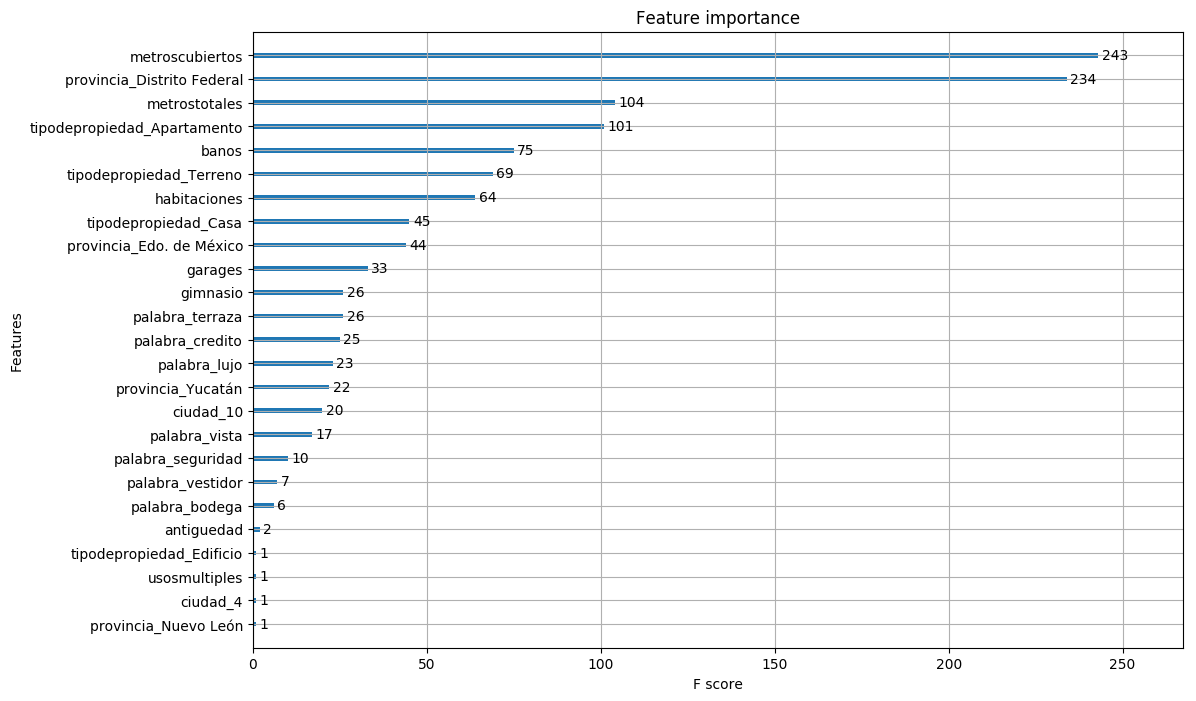

In [66]:
from xgboost import plot_importance

plot_importance(xgb_model)